# Part 1: KAN Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LinearSpline(nn.Module):
    """
    A learnable piecewise linear activation function (linear spline).
    Knots are trainable and define the shape of the activation.
    """
    def __init__(self, num_knots=5, init_scale=0.1, input_range=3.0):
        super().__init__()
        self.num_knots = num_knots

        # Initialize knot positions (x) linearly spaced in [-1, 1]
        # self.register_buffer("knot_x", torch.linspace(-1, 1, num_knots))
        self.register_buffer("knot_x", torch.linspace(-3, 3, num_knots))

        self.input_range = input_range  # New: expected input range (e.g., [-3,3])

        # Initialize knot values (y) randomly
        self.knot_y = nn.Parameter(torch.randn(num_knots) * init_scale)

    def forward(self, x):
        """
        Compute piecewise linear interpolation between knots.
        Args:
            x: Input tensor (any shape)
        Returns:
            Output tensor (same shape as x)
        """
        # # Rescale x to [-1, 1] for stability (optional)
        # x = torch.tanh(x)  # Ensures x ∈ [-1, 1]

        x = torch.clamp(x, -self.input_range, self.input_range)

        # Find the segment each x belongs to
        segments = torch.searchsorted(self.knot_x, x) - 1
        segments = segments.clamp(0, self.num_knots - 2)

        # Get neighboring knots
        x0 = self.knot_x[segments]
        x1 = self.knot_x[segments + 1]
        y0 = self.knot_y[segments]
        y1 = self.knot_y[segments + 1]

        # Linear interpolation: y = y0 + (y1 - y0) * (x - x0) / (x1 - x0)
        alpha = (x - x0) / (x1 - x0 + 1e-6)
        return y0 + alpha * (y1 - y0)

class KANLayer(nn.Module):
    """
    A single KAN layer with learnable piecewise linear activations.
    Replaces a traditional linear layer.
    """
    def __init__(self, input_dim, output_dim, num_knots=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Each edge has its own spline activation
        self.splines = nn.ModuleList([
            LinearSpline(num_knots) for _ in range(input_dim * output_dim)
        ])

        # Optional: Add a small trainable bias
        self.bias = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        out = torch.zeros(batch_size, self.output_dim).to(x.device)

        # Apply each spline to its corresponding input
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                spline_idx = i * self.output_dim + j
                out[:, j] += self.splines[spline_idx](x[:, i])

        return out + self.bias

class KAN(nn.Module):
    """
    A simple KAN with 2 layers (input -> hidden -> output).
    """
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_knots=5):
        super().__init__()
        self.layer1 = KANLayer(input_dim, hidden_dim, num_knots)
        self.layer2 = KANLayer(hidden_dim, output_dim, num_knots)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)  # Optional: Add fixed nonlinearity between KAN layers
        x = self.layer2(x)
        return x


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Part 2-3: Training on Toy Dataset and Analysis

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split

def generate_data(n_samples=5000, noise=0.1):
    x = np.random.uniform(-3, 3, (n_samples, 2))
    y = np.sin(x[:, 0]) + np.cos(x[:, 1]) + x[:, 0]**2 - x[:, 1]**2
    y += noise * np.random.randn(n_samples)
    return torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(1)

def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    start_time = time()
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
            val_losses.append(val_loss.item())

    training_time = time() - start_time
    return train_losses, val_losses, training_time

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = nn.MSELoss()(y_pred, y_test).item()
    return test_loss


Metric               KAN        MLP       
----------------------------------------
Parameters           3021       501       
Training Time (s)    77.44 2.28
Final Train MSE      0.0214 0.0441
Final Val MSE        0.0617 0.0409
Test MSE             0.0639 0.0428


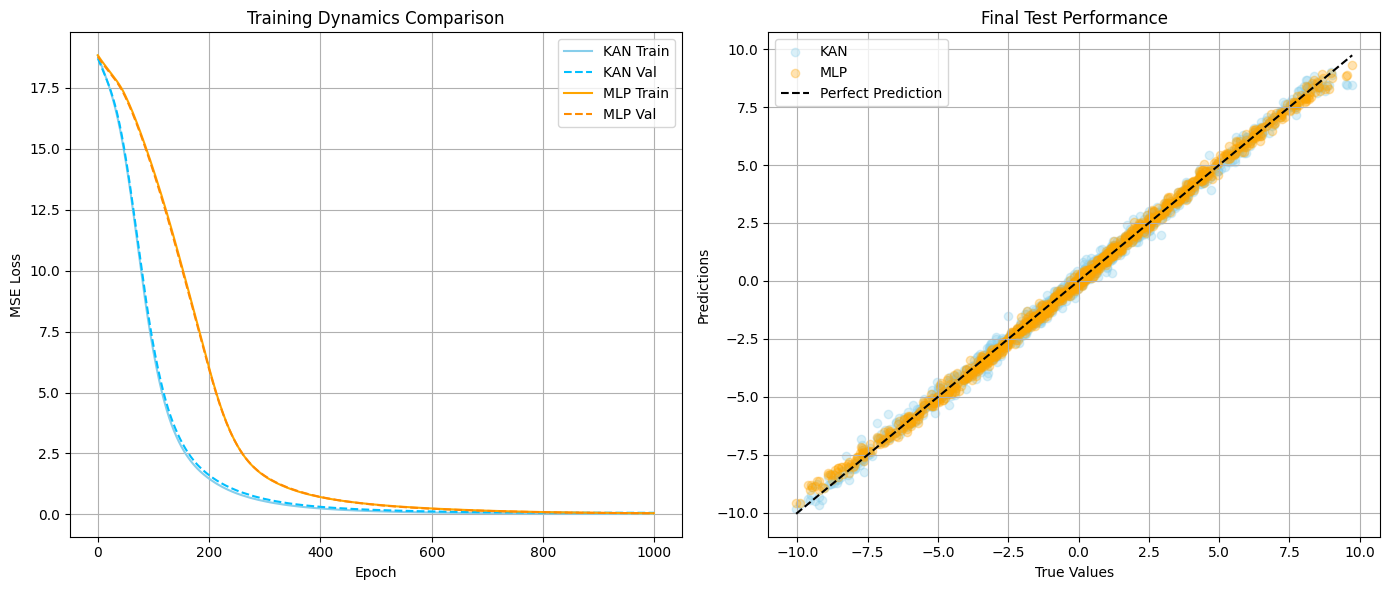

In [ ]:
# Generate and split data (60/20/20)
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25*0.8=0.2

# Initialize models
hidden_dim = 20
kan = KAN(input_dim=2, hidden_dim=hidden_dim, num_knots=50)
mlp = MLP(input_dim=2, hidden_dim=hidden_dim)

# Train models with validation
kan_train, kan_val, kan_time = train_model(kan, X_train, y_train, X_val, y_val)
mlp_train, mlp_val, mlp_time = train_model(mlp, X_train, y_train, X_val, y_val)

# Final evaluation on test set
kan_test = evaluate_model(kan, X_test, y_test)
mlp_test = evaluate_model(mlp, X_test, y_test)

# Count parameters
kan_params = sum(p.numel() for p in kan.parameters())
mlp_params = sum(p.numel() for p in mlp.parameters())

# Results
print(f"\n{'Metric':<20} {'KAN':<10} {'MLP':<10}")
print(f"{'-'*40}")
print(f"{'Parameters':<20} {kan_params:<10} {mlp_params:<10}")
print(f"{'Training Time (s)':<20} {kan_time:.2f} {mlp_time:.2f}")
print(f"{'Final Train MSE':<20} {kan_train[-1]:.4f} {mlp_train[-1]:.4f}")
print(f"{'Final Val MSE':<20} {kan_val[-1]:.4f} {mlp_val[-1]:.4f}")
print(f"{'Test MSE':<20} {kan_test:.4f} {mlp_test:.4f}")

# Plotting combined validation curves
plt.figure(figsize=(14, 6))

# Training Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(kan_train, label='KAN Train', color='skyblue', linestyle='-')
plt.plot(kan_val, label='KAN Val', color='deepskyblue', linestyle='--')
plt.plot(mlp_train, label='MLP Train', color='orange', linestyle='-')
plt.plot(mlp_val, label='MLP Val', color='darkorange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Dynamics Comparison')
plt.legend()
plt.grid(True)

# Test Prediction Comparison
plt.subplot(1, 2, 2)
plt.scatter(y_test.numpy(), kan(X_test).detach().numpy(),
            alpha=0.3, color='skyblue', label='KAN')
plt.scatter(y_test.numpy(), mlp(X_test).detach().numpy(),
            alpha=0.3, color='orange', label='MLP')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Final Test Performance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

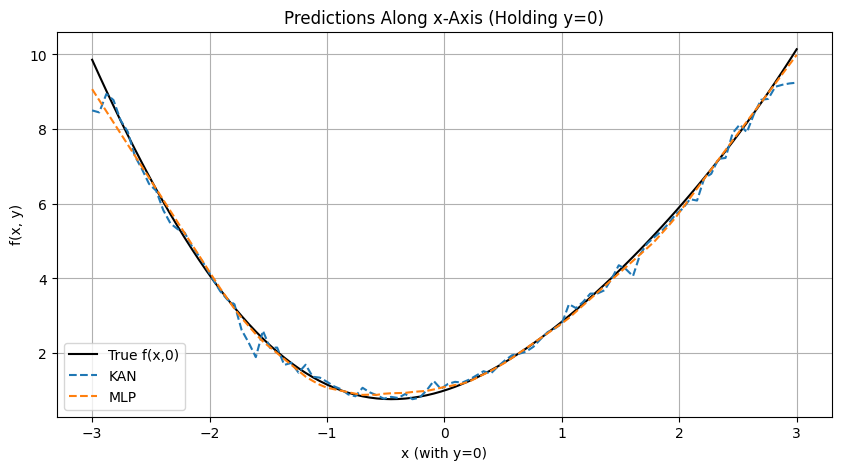

In [ ]:
# Plot predictions vs x (for fixed y=0)
x_plot = np.linspace(-3, 3, 100)
X_plot = torch.FloatTensor(np.column_stack((x_plot, np.zeros_like(x_plot))))
with torch.no_grad():
    y_kan = kan(X_plot).numpy()
    y_mlp = mlp(X_plot).numpy()

plt.figure(figsize=(10, 5))
plt.plot(x_plot, np.sin(x_plot) + 1 + x_plot**2, 'k-', label='True f(x,0)')
plt.plot(x_plot, y_kan, '--', label='KAN')
plt.plot(x_plot, y_mlp, '--', label='MLP')
plt.xlabel('x (with y=0)')
plt.ylabel('f(x, y)')
plt.legend()
plt.title('Predictions Along x-Axis (Holding y=0)')
plt.grid()
plt.show()

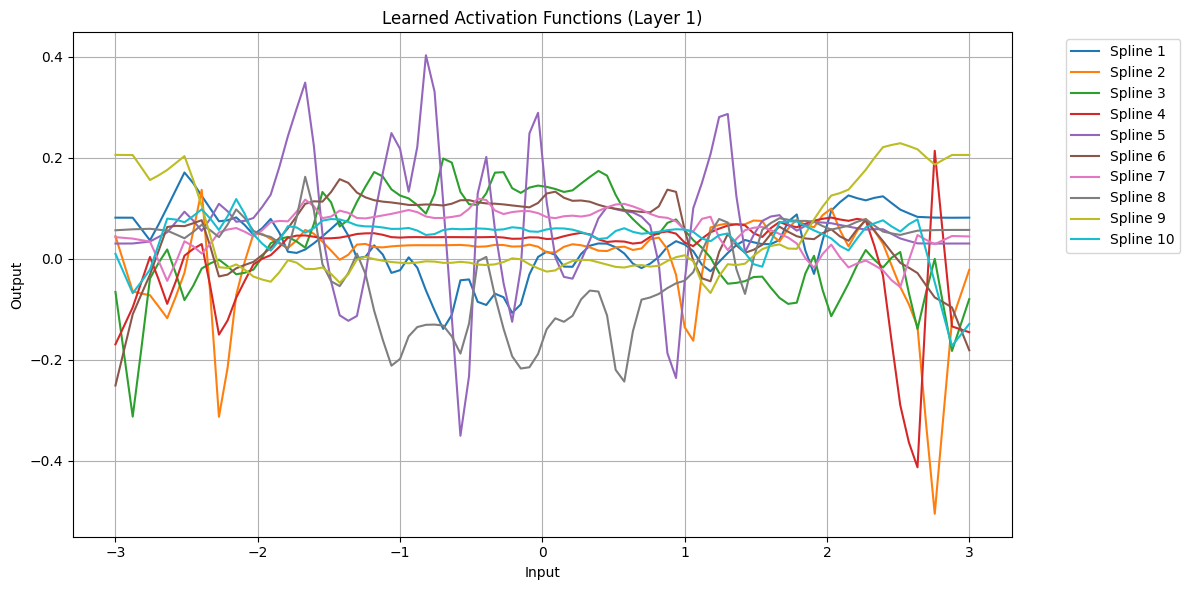

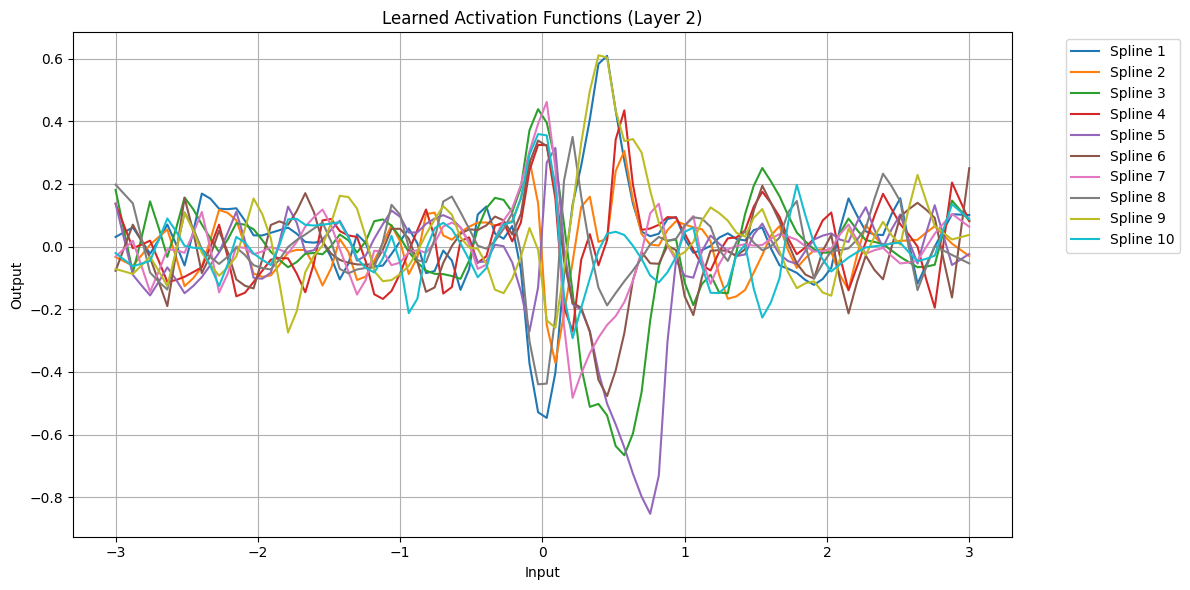

In [ ]:
def plot_kan_activations(model, layer_idx=0):
    """Visualize learned activation functions in a KAN layer"""
    layer = model.layer1 if layer_idx == 0 else model.layer2
    num_splines = len(layer.splines)

    # Create input range
    x = torch.linspace(-3, 3, 100).unsqueeze(1)

    plt.figure(figsize=(12, 6))
    for i, spline in enumerate(layer.splines[:10]):  # Plot first 10 for clarity
        with torch.no_grad():
            y = spline(x).numpy()

        plt.plot(x.numpy(), y, label=f'Spline {i+1}')

    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(f'Learned Activation Functions (Layer {layer_idx+1})')
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize first layer activations
plot_kan_activations(kan, layer_idx=0)  # First layer (input transformations)
plot_kan_activations(kan, layer_idx=1)  # Second layer (composition)